In [1]:
import dmc2gym
import utils
import os
import torch
import time
import numpy as np

from curl_sac import RadSacAgent
from torchvision import transforms

# for visualization
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis
import matplotlib.pyplot as plt

In [9]:
seed = 0
gpu_index = 0
data_aug = 'gray'  # 'crop' 'no_aug' 'gray' 'cutout' 'cutout_color' 'flip' 'rotate' 'color_jitter'

agent_type = 'rad_sac'
pre_step = 500000
domain_name = 'reacher'  # 'walker' 'cartpole' 'humanoid' finger ball_in_cup
task_name = 'spin' # 'walk' 'swingup' 'stand' spin
if 'walker'  in domain_name:
    task_name = 'walk'
if 'cheetah'  in domain_name:
    task_name = 'run'
if 'ball' in domain_name:
    task_name = 'catch'
if 'reacher' in domain_name:
    task_name = 'easy'    
root_dir = './results/'

env_name = domain_name + '-' + task_name
exp_name = env_name + '-im84-b128-s1234-pixel-' + data_aug
model_dir = root_dir + exp_name + '/model/'

encoder_type = 'pixel'
pre_transform_image_size = 100
image_size = 84
action_repeat = 4
frame_stack = 3
hidden_dim = 1024
discount = 0.99
init_temperature = 0.1
alpha_lr = 1e-4
alpha_beta = 0.5
actor_lr = 1e-3
actor_beta = 0.9
actor_log_std_min = -10
actor_log_std_max = 2
actor_update_freq = 2
critic_lr = 1e-3
critic_beta = 0.9
critic_tau = 0.01
critic_target_update_freq = 2
encoder_feature_dim = 50
encoder_lr = 1e-3
encoder_tau = 0.05
num_layers = 4
num_filters = 32
log_interval = 100
detach_encoder = False
curl_latent_dim = 128
num_eval_episodes = 1

if data_aug is not 'crop':
    pre_transform_image_size = 84

In [10]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_index)
utils.set_seed_everywhere(seed)
env = dmc2gym.make(    
    domain_name=domain_name,
    task_name=task_name,
    seed=seed,
    visualize_reward=False,
    from_pixels=(encoder_type == 'pixel'),
    height=pre_transform_image_size,
    width=pre_transform_image_size,
    frame_skip=action_repeat
)
env.seed(seed)

# stack several consecutive frames together
if encoder_type == 'pixel':
    env = utils.FrameStack(env, k=frame_stack)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
action_shape = env.action_space.shape

if encoder_type == 'pixel':
    obs_shape = (3*frame_stack, image_size, image_size)
    pre_aug_obs_shape = (3*frame_stack, pre_transform_image_size, pre_transform_image_size)
else:
    obs_shape = env.observation_space.shape
    pre_aug_obs_shape = obs_shape

In [11]:
def make_agent(obs_shape, action_shape, device):
    return RadSacAgent(
        obs_shape=obs_shape,
        action_shape=action_shape,
        device=device,
        hidden_dim=hidden_dim,
        discount=discount,
        init_temperature=init_temperature,
        alpha_lr=alpha_lr,
        alpha_beta=alpha_beta,
        actor_lr=actor_lr,
        actor_beta=actor_beta,
        actor_log_std_min=actor_log_std_min,
        actor_log_std_max=actor_log_std_max,
        actor_update_freq=actor_update_freq,
        critic_lr=critic_lr,
        critic_beta=critic_beta,
        critic_tau=critic_tau,
        critic_target_update_freq=critic_target_update_freq,
        encoder_type=encoder_type,
        encoder_feature_dim=encoder_feature_dim,
        encoder_lr=encoder_lr,
        encoder_tau=encoder_tau,
        num_layers=num_layers,
        num_filters=num_filters,
        log_interval=log_interval,
        detach_encoder=detach_encoder,
        latent_dim=curl_latent_dim,
        data_augs=data_aug,
    )

In [12]:
agent = make_agent(
    obs_shape=obs_shape,
    action_shape=action_shape,
    device=device,
)
agent.load(model_dir, pre_step)

AssertionError: invalid data aug string

In [13]:
attention_idx = 2
all_ep_rewards = []
start_time = time.time()
for i in range(num_eval_episodes):
    obs = env.reset()
    done = False
    episode_reward = 0
    obs_list = []
    attention_list = []
    while not done:
        # center crop image
        if encoder_type == 'pixel' and 'crop' in data_aug:
            obs = utils.center_crop_image(obs, image_size)
            
        with utils.eval_mode(agent):
            action, attention = agent.select_action_with_attention(obs / 255., attention_idx)
        obs_list.append(obs.astype('int16'))
        attention_list.append(attention)
        
        obs, reward, done, _ = env.step(action)
        episode_reward += reward

    print('episode_reward: ' + str(episode_reward))
    all_ep_rewards.append(episode_reward)

mean_ep_reward = np.mean(all_ep_rewards)
best_ep_reward = np.max(all_ep_rewards)

RuntimeError: size mismatch, m1: [1 x 59168], m2: [39200 x 50] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [ ]:
show_index = 5
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)
count = 0
start_index = show_index
for ax in axs.flat:
    ax.imshow(obs_list[start_index][(count)*3:(count+1)*3,:,:].swapaxes(2,0).swapaxes(1,0))
    count += 1
    if count == 3:
        start_index += 1
        count = 0
fig.savefig('temp.png')
plt.tight_layout()
plt.show()

IndexError: list index out of range

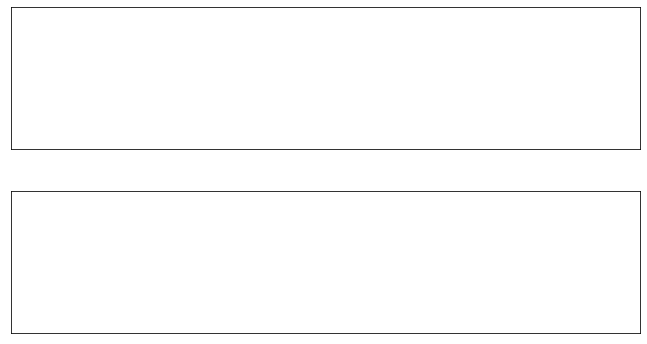

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9.3, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)
count = show_index
for ax in axs.flat:
    ax.imshow(attention_list[count])
    count += 1
plt.tight_layout()
plt.show()